# PRISMA Background-Matched Uncertainty Analysis

Extend the PRISMA uncertainty workflow by restricting the clutter estimate to plume-free pixels whose spectra (outside the two SWIR CH$_4$ windows) mimic the plume footprint. This guards against mixing unrelated land covers into $\sigma_{Surf}$ and keeps plume diagnostics tied to their true substrate.

**Highlights**
1. Load MF concentration/uncertainty rasters plus optional manual plume polygons.
2. Re-read the PRISMA L1 radiance cube and drop methane-sensitive bands before comparing spectra.
3. Build a spectral distance map and keep the closest plume-free pixels as the background pool; fall back to quantile-based plume masks when no shapefile is available.
4. Combine the matched background variance with $\sigma_{RMN}$ for plume-level uncertainty products and machine-readable metrics.


## Theoretical background
PRISMA shares the same uncertainty decomposition but introduces a grid mismatch: MF rasters live in geographic coordinates whereas the spectral cube remains in instrument geometry. We therefore convert the plume/background masks into the instrument grid using the latitude/longitude swaths, compute methane-free spectral distances there, and project the selected pixels back to the georegistered grid before evaluating $\sigma_{tot}$ and $\sigma_{Surf}$. This keeps the clutter term tied to surfaces with the same continuum signature as the plume.


In [1]:

import os
import sys
from pathlib import Path
import json
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts.satellites import prisma_utils


In [2]:

PIPELINE_OUTPUT_BASE = REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'prisma'
PRISMA_DATA_ROOT = REPO_ROOT / 'test_data' / 'prisma'
EKIZAK_ROOT = PRISMA_DATA_ROOT / 'Ekizak_Turkmenistan_20220912' / '20220912072502_20220912072506'
NORTHERN_ROOT = PRISMA_DATA_ROOT / 'Northern_State_Sudan_20200401' / '20200401085313_20200401085318'

SCENE_OPTIONS = {
    'ekizak_plume': {
        'scene_name': 'PRISMA Demo Scene (Ekizak plume)',
        'concentration': PIPELINE_OUTPUT_BASE / 'ekizak_plume' / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_concentration.tif',
        'uncertainty': PIPELINE_OUTPUT_BASE / 'ekizak_plume' / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_uncertainty.tif',
        'plume_mask': PIPELINE_OUTPUT_BASE / 'ekizak_plume' / 'plumes_mask_prisma_20220912072502.shp',
        'spectral_assets': {
            'sensor': 'prisma',
            'l1': EKIZAK_ROOT / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001.zip',
        },
    },
    'northern_state_background': {
        'scene_name': 'PRISMA Background Scene (Northern State, methane-free)',
        'concentration': PIPELINE_OUTPUT_BASE / 'northern_state_background' / 'PRS_L1_STD_OFFL_20200401085313_20200401085318_0001_MF_concentration.tif',
        'uncertainty': PIPELINE_OUTPUT_BASE / 'northern_state_background' / 'PRS_L1_STD_OFFL_20200401085313_20200401085318_0001_MF_uncertainty.tif',
        'plume_mask': None,
        'spectral_assets': {
            'sensor': 'prisma',
            'l1': NORTHERN_ROOT / 'PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.he5',
        },
    },
}

SELECTED_SCENE = 'ekizak_plume'
SCENE_CONFIG = SCENE_OPTIONS[SELECTED_SCENE]

SCENE_NAME = SCENE_CONFIG['scene_name']
SIGMA_RMN_AGGREGATION = 'mean'
METHANE_WINDOWS_NM = [(1625.0, 1695.0), (2100.0, 2450.0)]
METHANE_GUARD_NM = 8.0
SPECTRAL_MATCH_PERCENTILES = (10, 15, 20, 30, 40, 50)
AUTO_PLUME_PERCENTILES = (99.5, 99.0, 98.0, 97.0, 95.0)
MIN_BACKGROUND_PIXELS = 750
MIN_BACKGROUND_FRACTION = 0.01
AUTO_PLUME_MIN_PIXELS = 200

SUMMARY_DIR = NOTEBOOK_ROOT / 'outputs' / 'uncertainty' / 'prisma_spectral'
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Using plume mask: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/ekizak_plume/plumes_mask_prisma_20220912072502.shp
Background selection strategy: spectrally_matched
Matched 85113 pixels (percentile=10, threshold=0.411).


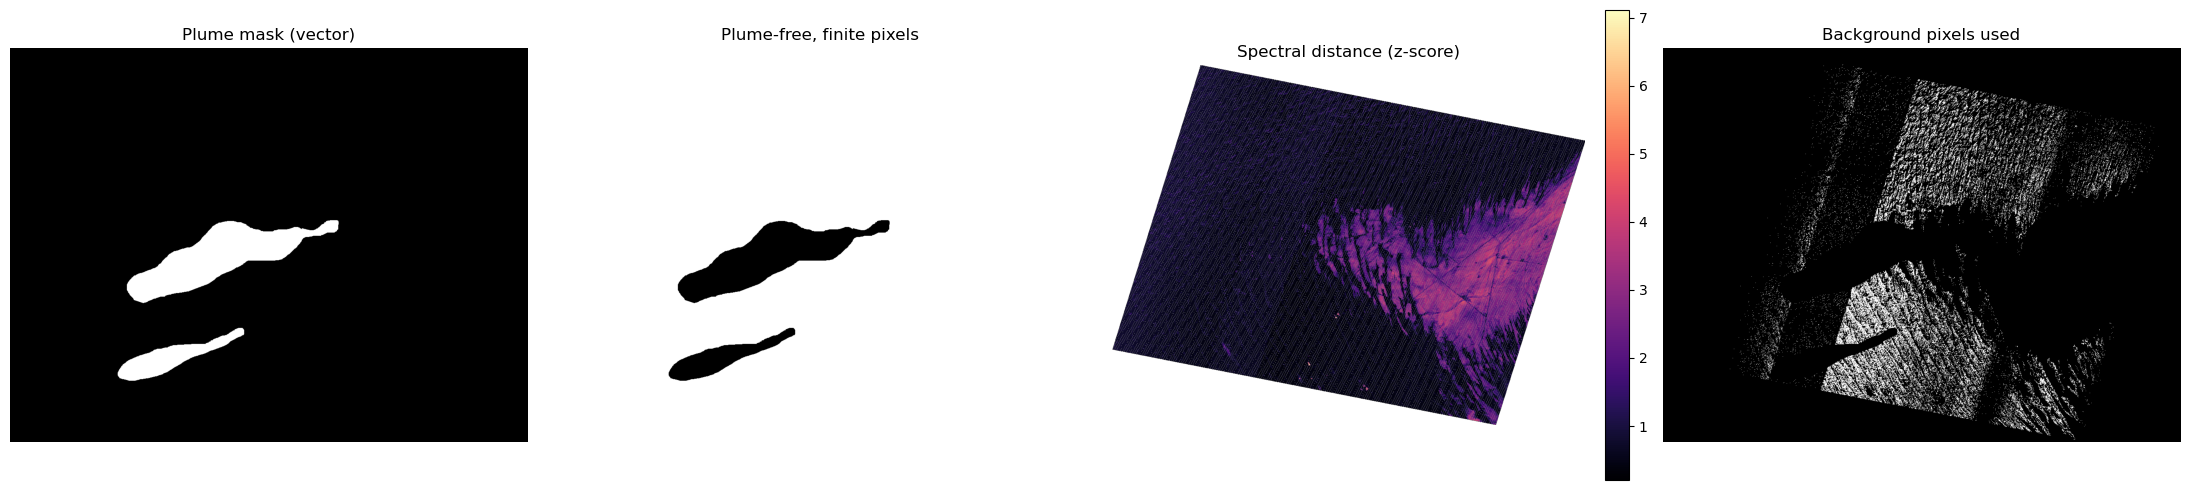

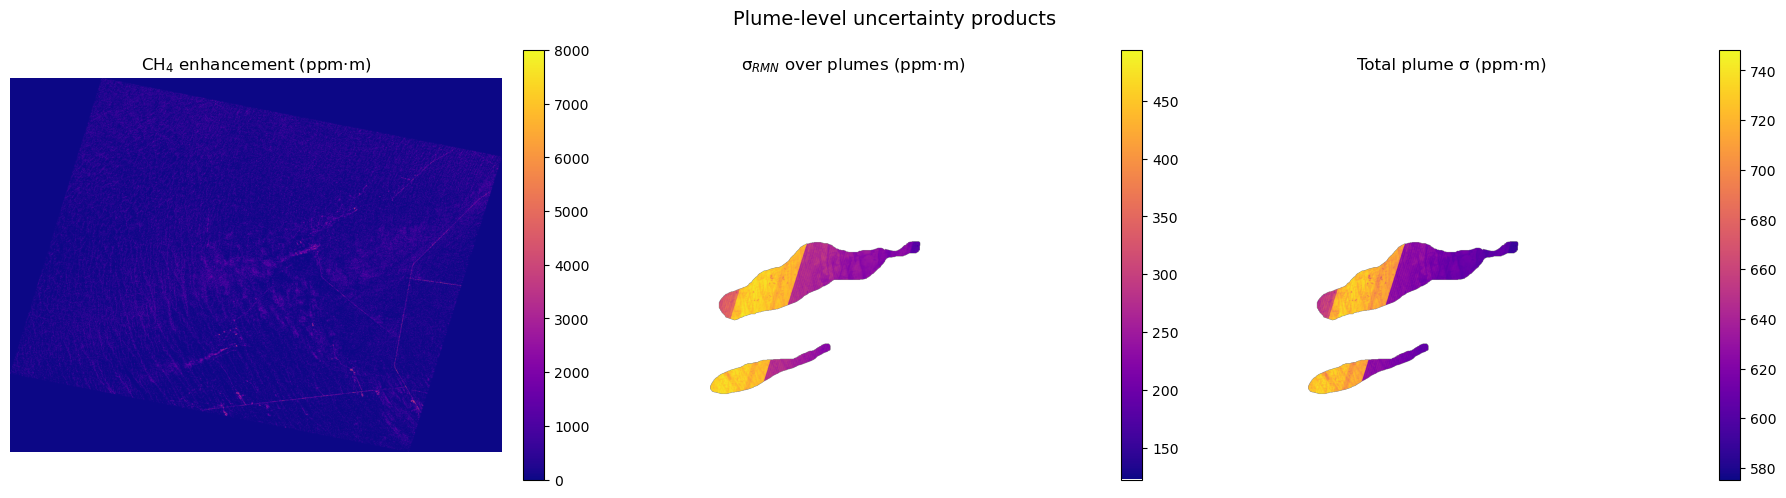

Scene noise metrics:
  scene: PRISMA Demo Scene (Ekizak plume)
  concentration_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/ekizak_plume/PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_concentration.tif
  uncertainty_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/ekizak_plume/PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_uncertainty.tif
  plume_mask_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/ekizak_plume/plumes_mask_prisma_20220912072502.shp
  plume_mask_source: vector
  auto_plume_threshold: None
  valid_pixels: 1217902
  background_pixels: 85113
  instrument_background_pixels: 93610
  background_strategy: spectrally_matched
  spectral_percentile: 10
  spectral_distance_threshold: 0.41084757447242737

In [3]:

def _read_raster(path: str):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    ds = None
    return arr, geo, proj


def _rasterize_vector(vector_path: str, rows: int, cols: int, geo_transform: tuple, projection: str) -> np.ndarray:
    vector_ds = ogr.Open(vector_path)
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    vector_layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], vector_layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    vector_layer = None
    vector_ds = None
    return mask_array


def _slugify(value: str) -> str:
    return ''.join(ch.lower() if ch.isalnum() else '_' for ch in value).strip('_')


def _mask_array(data: np.ndarray, mask: np.ndarray) -> np.ndarray:
    masked = np.full(data.shape, np.nan, dtype=float)
    masked[mask] = data[mask]
    return masked


def _auto_plume_mask(
    concentration: np.ndarray,
    finite_mask: np.ndarray,
    percentiles: tuple[float, ...],
    min_pixels: int,
):
    if not np.any(finite_mask):
        return None, {}
    values = concentration[finite_mask]
    if values.size == 0:
        return None, {}
    for perc in percentiles:
        threshold = float(np.nanpercentile(values, perc))
        candidate = (concentration >= threshold) & finite_mask
        if candidate.sum() >= min_pixels:
            return candidate, {'source': f'auto_percentile_{perc}', 'threshold': threshold}
    return None, {}


def _prepare_prisma_l1(path: Path) -> tuple[str, tempfile.TemporaryDirectory | None]:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f'PRISMA asset not found: {path}')
    if path.suffix.lower() == '.zip':
        temp_dir = tempfile.TemporaryDirectory()
        extracted = prisma_utils.extract_he5_from_zip(str(path), temp_dir.name)
        if not extracted:
            temp_dir.cleanup()
            raise FileNotFoundError(f'No .he5 file found inside {path}')
        return extracted, temp_dir
    return str(path), None


def _load_spectral_cube(assets: dict[str, Path | str]):
    l1_path, temp_dir = _prepare_prisma_l1(Path(assets['l1']))
    try:
        cube, cw_matrix, _, _, _, _, latitude_vnir, longitude_vnir, latitude_swir, longitude_swir = prisma_utils.prisma_read(l1_path)
    finally:
        if temp_dir is not None:
            temp_dir.cleanup()
    cube = cube.astype(np.float32)
    wavelengths = np.mean(cw_matrix, axis=0).astype(np.float32)
    lat_grid = np.rot90(latitude_swir, k=-1).astype(np.float32)
    lon_grid = np.rot90(longitude_swir, k=-1).astype(np.float32)
    finite_mask = np.all(np.isfinite(cube), axis=2)
    return {
        'cube': cube,
        'wavelengths': wavelengths,
        'lat': lat_grid,
        'lon': lon_grid,
        'finite_mask': finite_mask,
    }


# Drop methane absorption bands (with a guard) so spectral similarity measures only continuum-driven clutter
def _band_mask(wavelengths: np.ndarray, windows: list[tuple[float, float]], guard_nm: float) -> np.ndarray:
    wav = np.asarray(wavelengths, dtype=float).ravel()
    mask = np.ones_like(wav, dtype=bool)
    for lo, hi in windows:
        lower = lo - guard_nm
        upper = hi + guard_nm
        mask &= ~((wav >= lower) & (wav <= upper))
    return mask


# Mahalanobis-like metric that favours plume-free pixels matching the plume background
def _spectral_distance(cube: np.ndarray, ref_mean: np.ndarray, ref_std: np.ndarray) -> np.ndarray:
    standardized = (cube - ref_mean) / ref_std
    return np.sqrt(np.nanmean(standardized**2, axis=2))


def _select_background(
    distance_map: np.ndarray,
    candidate_mask: np.ndarray,
    percentiles: tuple[float, ...],
    min_fraction: float,
    min_pixels: int,
    fallback_percentile: float = 70.0,
):
    candidate_values = distance_map[candidate_mask]
    if candidate_values.size == 0:
        return candidate_mask & False, None, None
    min_required = max(int(np.ceil(candidate_values.size * min_fraction)), int(min_pixels))
    for perc in percentiles:
        threshold = float(np.nanpercentile(candidate_values, perc))
        mask = (distance_map <= threshold) & candidate_mask
        if mask.sum() >= min_required:
            return mask, threshold, perc
    threshold = float(np.nanpercentile(candidate_values, fallback_percentile))
    mask = (distance_map <= threshold) & candidate_mask
    return mask, threshold, fallback_percentile


def _latlon_to_pixel(lat: np.ndarray, lon: np.ndarray, geo_transform: tuple) -> tuple[np.ndarray, np.ndarray]:
    a, b, c, d, e, f = geo_transform
    denom = b * f - c * e
    if denom == 0:
        raise ValueError('Non-invertible geotransform encountered.')
    x = lon - a
    y = lat - d
    col = (f * x - c * y) / denom
    row = (-e * x + b * y) / denom
    return row, col


# Project georegistered masks (GeoTIFF grid) onto the instrument sampling so spectra are compared natively
def _geo_mask_to_instrument(mask_geo: np.ndarray, lat_grid: np.ndarray, lon_grid: np.ndarray, geo_transform: tuple) -> np.ndarray:
    rows, cols = _latlon_to_pixel(lat_grid, lon_grid, geo_transform)
    rows_idx = np.rint(rows).astype(int)
    cols_idx = np.rint(cols).astype(int)
    valid = (
        np.isfinite(rows_idx)
        & np.isfinite(cols_idx)
        & (rows_idx >= 0)
        & (cols_idx >= 0)
        & (rows_idx < mask_geo.shape[0])
        & (cols_idx < mask_geo.shape[1])
    )
    instrument_mask = np.zeros(lat_grid.shape, dtype=bool)
    instrument_mask[valid] = mask_geo[rows_idx[valid], cols_idx[valid]]
    return instrument_mask


def _instrument_mask_to_geo(mask_instr: np.ndarray, lat_grid: np.ndarray, lon_grid: np.ndarray, geo_transform: tuple, geo_shape: tuple[int, int]) -> np.ndarray:
    rows, cols = _latlon_to_pixel(lat_grid, lon_grid, geo_transform)
    rows_flat = rows.ravel()
    cols_flat = cols.ravel()
    mask_vals = mask_instr.ravel()
    valid = mask_vals & np.isfinite(rows_flat) & np.isfinite(cols_flat)
    rows_idx = np.rint(rows_flat[valid]).astype(int)
    cols_idx = np.rint(cols_flat[valid]).astype(int)
    in_bounds = (
        (rows_idx >= 0)
        & (cols_idx >= 0)
        & (rows_idx < geo_shape[0])
        & (cols_idx < geo_shape[1])
    )
    rows_idx = rows_idx[in_bounds]
    cols_idx = cols_idx[in_bounds]
    counts = np.zeros(geo_shape, dtype=np.int32)
    np.add.at(counts, (rows_idx, cols_idx), 1)
    return counts > 0


def _instrument_scalar_to_geo(values: np.ndarray, lat_grid: np.ndarray, lon_grid: np.ndarray, geo_transform: tuple, geo_shape: tuple[int, int]) -> np.ndarray:
    rows, cols = _latlon_to_pixel(lat_grid, lon_grid, geo_transform)
    rows_flat = rows.ravel()
    cols_flat = cols.ravel()
    vals = values.ravel()
    valid = np.isfinite(vals) & np.isfinite(rows_flat) & np.isfinite(cols_flat)
    rows_idx = np.rint(rows_flat[valid]).astype(int)
    cols_idx = np.rint(cols_flat[valid]).astype(int)
    in_bounds = (
        (rows_idx >= 0)
        & (cols_idx >= 0)
        & (rows_idx < geo_shape[0])
        & (cols_idx < geo_shape[1])
    )
    rows_idx = rows_idx[in_bounds]
    cols_idx = cols_idx[in_bounds]
    vals = vals[valid][in_bounds]
    sum_arr = np.zeros(geo_shape, dtype=np.float64)
    count_arr = np.zeros(geo_shape, dtype=np.int32)
    np.add.at(sum_arr, (rows_idx, cols_idx), vals)
    np.add.at(count_arr, (rows_idx, cols_idx), 1)
    out = np.full(geo_shape, np.nan, dtype=np.float32)
    valid_cells = count_arr > 0
    out[valid_cells] = (sum_arr[valid_cells] / count_arr[valid_cells]).astype(np.float32)
    return out


def _derive_matched_background(
    scene_config: dict,
    plume_mask_geo: np.ndarray | None,
    base_mask_geo: np.ndarray,
    geo_transform: tuple,
    spectral_context: dict | None,
):
    if not spectral_context:
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'missing_assets', 'distance_map': None}
    if plume_mask_geo is None or not np.any(plume_mask_geo):
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'missing_plume_mask', 'distance_map': None}

    cube = spectral_context['cube']
    lat_grid = spectral_context['lat']
    lon_grid = spectral_context['lon']
    wavelengths = spectral_context['wavelengths']

    plume_mask_instr = _geo_mask_to_instrument(plume_mask_geo, lat_grid, lon_grid, geo_transform)
    base_mask_instr = _geo_mask_to_instrument(base_mask_geo, lat_grid, lon_grid, geo_transform)

    windows = scene_config.get('methane_windows_nm', METHANE_WINDOWS_NM)
    guard = scene_config.get('methane_guard_nm', METHANE_GUARD_NM)
    usable_bands = _band_mask(wavelengths, windows, guard)
    if not np.any(usable_bands):
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'no_usable_bands', 'distance_map': None}

    cube_subset = cube[:, :, usable_bands]
    finite_subset = np.all(np.isfinite(cube_subset), axis=2)
    plume_reference = cube_subset[plume_mask_instr & finite_subset]
    if plume_reference.size == 0:
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'no_reference_pixels', 'distance_map': None}

    ref_mean = np.nanmedian(plume_reference, axis=0)
    ref_std = np.nanstd(plume_reference, axis=0, ddof=1)
    ref_std = np.where(ref_std > 0, ref_std, 1.0)

    candidate_mask = base_mask_instr & finite_subset
    if not np.any(candidate_mask):
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'no_candidate_pixels', 'distance_map': None}

    distance_map = _spectral_distance(cube_subset, ref_mean, ref_std)
    matched_mask, threshold, percentile = _select_background(
        distance_map,
        candidate_mask,
        scene_config.get('spectral_match_percentiles', SPECTRAL_MATCH_PERCENTILES),
        scene_config.get('min_background_fraction', MIN_BACKGROUND_FRACTION),
        scene_config.get('min_background_pixels', MIN_BACKGROUND_PIXELS),
    )
    if matched_mask.sum() == 0:
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'selection_empty', 'distance_map': None}

    background_mask_geo = _instrument_mask_to_geo(matched_mask, lat_grid, lon_grid, geo_transform, base_mask_geo.shape)
    distance_map_geo = _instrument_scalar_to_geo(distance_map, lat_grid, lon_grid, geo_transform, base_mask_geo.shape)

    info = {
        'strategy': 'spectrally_matched',
        'percentile': percentile,
        'threshold': threshold,
        'reference_pixels': int(plume_reference.shape[0]),
        'usable_bands': int(cube_subset.shape[2]),
        'instrument_background_pixels': int(matched_mask.sum()),
        'distance_map': distance_map_geo,
    }
    return background_mask_geo, info


concentration, geo_transform, projection = _read_raster(str(SCENE_CONFIG['concentration']))
uncertainty, _, _ = _read_raster(str(SCENE_CONFIG['uncertainty']))

if concentration.shape != uncertainty.shape:
    raise ValueError('Concentration and uncertainty rasters must share the same shape.')

plume_mask = None
plume_mask_source = 'none'
plume_mask_meta: dict[str, float] = {}
if SCENE_CONFIG.get('plume_mask') and SCENE_CONFIG['plume_mask'].exists():
    print(f"Using plume mask: {SCENE_CONFIG['plume_mask']}")
    plume_mask = _rasterize_vector(
        str(SCENE_CONFIG['plume_mask']),
        concentration.shape[0],
        concentration.shape[1],
        geo_transform,
        projection,
    )
    plume_mask_source = 'vector'
else:
    print('No plume shapefile found; attempting automatic plume mask from concentration percentiles.')

finite_only = np.isfinite(concentration) & np.isfinite(uncertainty)
if plume_mask is None:
    auto_mask, meta = _auto_plume_mask(
        concentration,
        finite_only,
        percentiles=AUTO_PLUME_PERCENTILES,
        min_pixels=AUTO_PLUME_MIN_PIXELS,
    )
    if auto_mask is not None:
        plume_mask = auto_mask
        plume_mask_source = meta.get('source', 'auto_percentile')
        plume_mask_meta = meta
        thresh = meta.get('threshold')
        if thresh is not None:
            print(f"Auto-derived plume mask ({plume_mask_source}) with threshold {thresh:.2f} ppm·m.")
        else:
            print(f'Auto-derived plume mask using {plume_mask_source} percentiles.')
    else:
        print('Automatic plume mask derivation failed; treating entire scene as plume-free background.')

if plume_mask is not None:
    plume_free_mask = ~plume_mask
else:
    plume_free_mask = np.ones_like(concentration, dtype=bool)

plume_free_finite_mask = plume_free_mask & finite_only
if not np.any(plume_free_finite_mask):
    raise ValueError('No valid plume-free pixels available for statistics.')

spectral_context = None
if SCENE_CONFIG.get('spectral_assets'):
    try:
        spectral_context = _load_spectral_cube(SCENE_CONFIG['spectral_assets'])
    except Exception as exc:
        print(f'Unable to load spectral assets: {exc}')

background_mask, background_info = _derive_matched_background(
    SCENE_CONFIG,
    plume_mask,
    plume_free_finite_mask,
    geo_transform,
    spectral_context,
)
if background_mask is None or not np.any(background_mask):
    background_mask = plume_free_finite_mask
    background_info = background_info or {}
    background_info.setdefault('strategy', 'plume_free_fallback')

strategy = background_info.get('strategy', 'plume_free')
print(f'Background selection strategy: {strategy}')
if strategy == 'spectrally_matched':
    threshold = background_info.get('threshold')
    percentile = background_info.get('percentile')
    description = f"percentile={percentile}"
    if threshold is not None:
        description += f", threshold={threshold:.3f}"
    print(f"Matched {int(background_mask.sum())} pixels ({description}).")
else:
    print('Falling back to plume-free finite pixels for clutter estimation.')

distance_map = background_info.get('distance_map')
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
axes[0].imshow(plume_mask if plume_mask is not None else np.zeros_like(concentration, dtype=bool), cmap='gray')
axes[0].set_title(f'Plume mask ({plume_mask_source})')
axes[1].imshow(plume_free_finite_mask, cmap='gray')
axes[1].set_title('Plume-free, finite pixels')
if distance_map is not None:
    im = axes[2].imshow(np.ma.masked_invalid(distance_map), cmap='magma')
    axes[2].set_title('Spectral distance (z-score)')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
else:
    axes[2].imshow(np.zeros_like(concentration, dtype=float), cmap='gray')
    axes[2].set_title('Spectral distance unavailable')
axes[3].imshow(background_mask, cmap='gray')
axes[3].set_title('Background pixels used')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

if not np.any(background_mask):
    raise ValueError('No background pixels available after selection.')

delta_x = concentration[background_mask]
sigma_tot = float(np.nanstd(delta_x, ddof=1))

sigma_rmn_vals = uncertainty[background_mask]
agg = SIGMA_RMN_AGGREGATION.lower().strip()
if agg == 'median':
    sigma_rmn_stat = float(np.nanmedian(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmedian(sigma_rmn_vals ** 2))
else:
    sigma_rmn_stat = float(np.nanmean(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmean(sigma_rmn_vals ** 2))

# Quadrature difference isolates clutter from the plume-like variance by removing detector noise
sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))

if plume_mask is not None:
    plume_pixels_mask = plume_mask & finite_only
else:
    print('Plume mask missing: plume-level summaries will cover the whole scene.')
    plume_pixels_mask = finite_only

plume_pixel_count = int(plume_pixels_mask.sum())
if plume_pixel_count == 0:
    raise ValueError('No plume pixels available for plume-level uncertainty mapping.')

plume_concentration = _mask_array(concentration, plume_pixels_mask)
plume_sigma_rmn = _mask_array(uncertainty, plume_pixels_mask)
plume_sigma_total = _mask_array(np.sqrt(np.maximum(0.0, uncertainty ** 2 + sigma_surf ** 2)), plume_pixels_mask)

plume_sigma_rmn_mean = float(np.nanmean(plume_sigma_rmn[plume_pixels_mask]))
plume_sigma_total_mean = float(np.nanmean(plume_sigma_total[plume_pixels_mask]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(concentration, cmap='plasma', vmin=0, vmax=8000)
axes[0].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plume_sigma_rmn, cmap='plasma')
axes[1].set_title('σ$_{RMN}$ over plumes (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plume_sigma_total, cmap='plasma')
axes[2].set_title('Total plume σ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes:
    ax.axis('off')

plt.suptitle('Plume-level uncertainty products', fontsize=14)
plt.tight_layout()
plt.show()

metrics = {
    'scene': SCENE_NAME,
    'concentration_path': str(SCENE_CONFIG['concentration']),
    'uncertainty_path': str(SCENE_CONFIG['uncertainty']),
    'plume_mask_path': str(SCENE_CONFIG['plume_mask']) if SCENE_CONFIG.get('plume_mask') else None,
    'plume_mask_source': plume_mask_source,
    'auto_plume_threshold': plume_mask_meta.get('threshold'),
    'valid_pixels': int(plume_free_finite_mask.sum()),
    'background_pixels': int(background_mask.sum()),
    'instrument_background_pixels': background_info.get('instrument_background_pixels'),
    'background_strategy': background_info.get('strategy'),
    'spectral_percentile': background_info.get('percentile'),
    'spectral_distance_threshold': background_info.get('threshold'),
    'spectral_reference_pixels': background_info.get('reference_pixels'),
    'spectral_usable_bands': background_info.get('usable_bands'),
    'methane_windows_nm': METHANE_WINDOWS_NM,
    'methane_guard_nm': METHANE_GUARD_NM,
    'plume_pixels': plume_pixel_count,
    'sigma_tot': sigma_tot,
    'sigma_rmn_sq': sigma_rmn_sq,
    'sigma_rmn_value': sigma_rmn_stat,
    'sigma_surf': sigma_surf,
    'sigma_rmn_aggregation': agg,
    'mean_plume_sigma_rmn': plume_sigma_rmn_mean,
    'mean_plume_sigma_total': plume_sigma_total_mean,
}

metrics_path = SUMMARY_DIR / f"{_slugify(SCENE_NAME)}_noise_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print('Scene noise metrics:')
for key, value in metrics.items():
    print(f'  {key}: {value}')
print(f'Saved metrics to {metrics_path}')



## Result interpretation
The spectral-distance diagnostics reveal whether the clutter term was computed from plume-like pixels or the fallback plume-free mask. Use the JSON summary to track the selection percentile, methane windows, and matched pixel counts so downstream reports can explain how $\sigma_{Surf}$ was derived for each PRISMA scene.
